# Actor-Critic

<img src="media/actor_critic_flow.png" alt="drawing" width="600"/>

### Actor's Role

- **Purpose**: Learns what actions to take in each state
- **Output**: Probability distribution over possible actions
- **Learning Signal**: How good was the chosen action compared to expected?
- **Process**:
  - Takes state as input
  - Outputs action probabilities
  - Samples actions from this distribution
  - Updates based on how good the actions turned out to be

  ```python
  # Actor output (action probabilities)
  action_prob = F.softmax(action_pred, dim=-1)
  dist = Categorical(action_prob)

  # Policy Loss
  policy_loss = -(returns * log_prob_actions).sum()
  ```
### Critic's Role
- **Purpose**: Learns to estimate how good each state is
- **Output**: V(s) - the expected sum of future rewards from this state
- **Learning Signal**: How close was the prediction to actual returns?
- **Process**:
  - Takes state as input
  - Estimates the value of being in that state
  - Updates based on actual returns observed

  ```python
  # Critic output (state value prediction)
  value_pred = handler.actor_critic_policy(state)[1]

  # Value Loss
  value_loss = F.smooth_l1_loss(returns, values).sum()
  ```

### Policy Loss
- **Purpose**: Improve the actor's action selection
- **Components**:
  - *log_prob_actions*: Log probability of chosen actions
  - *returns*: Actual returns received
  - *Negative sign*: We minimize loss = maximize probability × return

  ```python
  policy_loss = -(returns * log_prob_actions).sum()
  ```

- **Interpretation**:
  - High return & high log prob → Large negative loss → Encourage this action
  - Low return & high log prob → Small negative loss → Discourage this action

- **Example**:
  ```python
  # If return = 10 and log_prob = -2:
  loss = -(10 * -2) = 20  # High loss, discourage

  # If return = 10 and log_prob = -0.5:
  loss = -(10 * -0.5) = 5  # Lower loss, encourage
  ```

### Value Loss
- **Purpose**: Improve the critic's value predictions
- **Components**:
  - values: Predicted state values V(s)
  - returns: Actual discounted returns
  - Huber/Smooth L1 loss: Robust to outliers


- **Interpretation**:
  - Small difference → Small loss → Good prediction
  - Large difference → Large loss → Poor prediction

  ```python
  value_loss = F.smooth_l1_loss(returns, values).sum()
  ```

- **Example**:
  ```python
  # If predicted value = 5 and actual return = 4.8:
  loss ≈ 0.04  # Small loss, good prediction

  # If predicted value = 5 and actual return = 8:
  loss ≈ 9  # Larger loss, poor prediction
  ```

### Actor-Critic Combination

  ```python
  # Combined learning step
  self.optimizer.zero_grad()
  policy_loss.backward()
  value_loss.backward()
  self.optimizer.step()
  ```
  
- Critic helps reduce variance in policy updates
- Better value estimates → More accurate policy updates
- Policy improvement → Better state visitation → Better value estimates
- They form a positive feedback loop:
  - Critic estimates state values
  - Actor uses these estimates to improve action selection
  - Better actions lead to better state value estimates
  - Cycle continues

The key synergy is that the critic provides a learned baseline (state values) that helps the actor determine whether an action was better or worse than expected, reducing the variance in policy updates and speeding up learning.

## Environment

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt

env = gym.make("LunarLander-v3", continuous=False, render_mode="rgb_array")

# Get number of actions from gym action space
n_actions = int(env.action_space.n)
print(f"Number of possible actions: {n_actions}")
print("""Actions:
0: do nothing
1: fire left orientation engine
2: fire main engine
3: fire right orientation engine
""")

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
print(f"Number of state observations: {n_observations}")

print("""State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      """)
print("Current state: ", state)

print("""Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      """)

Number of possible actions: 4
Actions:
0: do nothing
1: fire left orientation engine
2: fire main engine
3: fire right orientation engine

Number of state observations: 8
State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      
Current state:  [ 0.00305061  1.4079074   0.3089853  -0.13390324 -0.00352817 -0.06998975
  0.          0.        ]
Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      


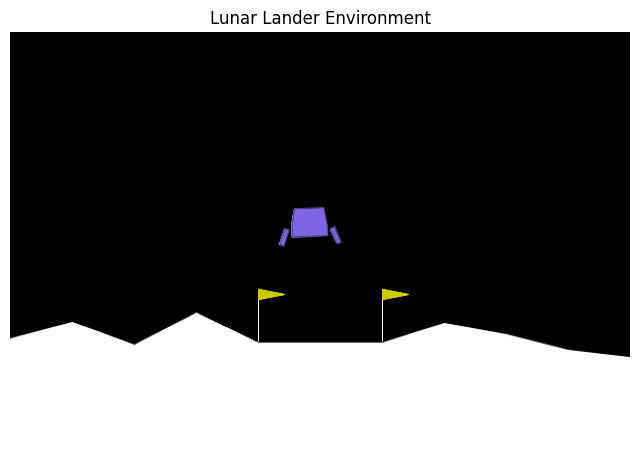

In [2]:
# Reset the environment to get the initial state
state, info = env.reset()

for i in range(50):
    env.step(action=0)
# Render the environment to get an RGB image
frame = env.render()

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(frame)
plt.axis("off")
plt.title("Lunar Lander Environment")
plt.show()

In [ ]:
import matplotlib

# set up matplotlib
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


def plot_metrics(episode_durations, rewards, show_result=False, save_path=None):
    # Create a horizontal figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), dpi=100)
    fig.suptitle("Training Metrics" if not show_result else "Results", fontsize=16)

    # Plot Episode Durations
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    axes[0].set_title("Episode Durations")
    axes[0].set_xlabel("Episode")
    axes[0].set_ylabel("Duration")
    axes[0].plot(durations_t.numpy(), label="Duration")

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        axes[0].plot(means.numpy(), label="100-Episode Avg", linestyle="--")

    axes[0].legend()

    # Plot Rewards
    rewards_t = torch.tensor(rewards, dtype=torch.float)
    axes[1].set_title("Rewards")
    axes[1].set_xlabel("Episode")
    axes[1].set_ylabel("Reward")
    axes[1].plot(rewards_t.numpy(), label="Reward")

    if len(rewards_t) >= 100:
        reward_means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        reward_means = torch.cat((torch.zeros(99), reward_means))
        axes[1].plot(reward_means.numpy(), label="100-Episode Avg", linestyle="--")

    axes[1].legend()

    # Adjust layout and save/show
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Add space for the suptitle
    if save_path:
        plt.savefig(save_path + ".png", dpi=300)
        print(f"Metrics figure saved to {save_path}")

    if "get_ipython" in globals():
        if not show_result:
            display.clear_output(wait=True)
            display.display(fig)
        else:
            display.display(fig)
    else:
        plt.show()

    plt.close(fig)

In [4]:
from datetime import datetime
from typing import List, Tuple

import numpy as np
import pandas as pd
import torch.nn.functional as F
from numpy.typing import NDArray
from torch.distributions import Categorical
from torch.optim import Adam

from models import MLP

## Policy

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1)

In [6]:
class PolicyNetwork(nn.Module):
    """
    Neural network for policy-based reinforcement learning.

    Architecture:
    - Input layer: Accepts `num_inputs` features representing the state.
    - Hidden layers: Two fully connected layers with 256 units each and ReLU activation for non-linearity.
    - Output layer: Produces `num_outputs`, representing action space size or logits.

    Args:
        num_inputs (int): Number of input features (state size).
        num_outputs (int): Number of output features (action size).

    Methods:
        forward(x): Propagates the input through the network.
    """

    def __init__(self, num_inputs: int, num_outputs: int) -> None:
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(num_inputs, 256), nn.ReLU(), nn.Linear(256, 256), nn.ReLU(), nn.Linear(256, num_outputs)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, num_inputs).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, num_outputs).
        """
        return self.net(x)

In [7]:
class ActorCriticAgent:
    def __init__(
        self,
        policy_network: nn.Module,
        critic_network: nn.Module,
        discount_factor: float = 0.99,
        normalize_rewards: bool = True,
        device: torch.device = torch.device("cpu"),
        learning_rate: float = 3e-3,
    ) -> None:
        self.actor_critic = ActorCritic(policy_network, critic_network).to(device)
        self.optimizer = Adam(params=self.actor_critic.parameters(), lr=learning_rate)

        self.gamma = discount_factor

    def compute_discounted_returns(self, rewards: torch.Tensor) -> torch.Tensor:
        """
        Computes discounted returns for a sequence of rewards.

        Args:
            rewards (torch.Tensor): Rewards for the episode.
            gamma (float): Discount factor.

        Returns:
            torch.Tensor: Discounted returns.
        """
        discounted_returns = []
        cumulative_return = 0.0
        for reward in reversed(rewards):
            cumulative_return = reward + self.gamma * cumulative_return
            discounted_returns.insert(0, cumulative_return)

        discounted_returns = torch.tensor(discounted_returns, dtype=torch.float32)

        return (discounted_returns - discounted_returns.mean()) / (discounted_returns.std() + 1e-8)

    def select_action(self, state: torch.Tensor) -> Tuple[int, torch.Tensor]:
        """
        Selects an action based on the current state and computes its log-probability.

        Args:
            state (torch.Tensor): The current state represented as a tensor.

        Returns:
            Tuple[int, torch.Tensor]:
                - action (int): The chosen action index.
                - log_prob (torch.Tensor): The log-probability of the chosen action.
        """
        # Forward pass through the policy network to get action logits.
        action_logits = self.actor_critic.policy_network(state)

        # Create a categorical distribution from the logits.
        action_distribution = Categorical(logits=action_logits)

        # Sample an action from the distribution.
        sampled_action = action_distribution.sample()

        # Convert the sampled action to a Python integer.
        action_index = int(sampled_action.item())

        # Calculate the log-probability of the selected action.
        log_prob = action_distribution.log_prob(sampled_action)

        return action_index, log_prob

    def calculate_policy_loss(
        self, episode_log_probability_actions: torch.Tensor, episode_action_rewards: torch.Tensor
    ):
        """
        The loss is negated because most optimization libraries (like PyTorch) perform minimization,
        while the policy gradient aims to maximize the objective J(θ).
        """
        return -(episode_log_probability_actions * episode_action_rewards).mean()

    def calculate_value_loss(self, returns: torch.Tensor, values: torch.Tensor):
        values = values.squeeze(1)
        return F.smooth_l1_loss(returns, values).mean()  # SUM?

    def optimize(
        self, returns: torch.Tensor, log_prob_actions: torch.Tensor, values: torch.Tensor
    ) -> Tuple[float, float]:
        # Detach returns to avoid unnecessary gradient computation
        # returns = returns.detach()

        # Compute policy loss (negative log probability of actions scaled by returns)
        policy_loss = self.calculate_policy_loss(log_prob_actions, returns)

        # Compute value loss (using smooth L1 loss, aka Huber loss)
        value_loss = self.calculate_value_loss(returns, values)

        # Perform optimizer steps for both policy and value losses
        self.optimizer.zero_grad()

        loss = policy_loss + value_loss

        loss.backward()

        self.optimizer.step()

        # Return scalar losses as Python floats
        return policy_loss.item(), value_loss.item()

## Neural Network Initialization

In [8]:
actor_network = PolicyNetwork(n_observations, n_actions)
critic_network = MLP(input_dim=n_observations, output_dim=1)

In [9]:
class ActorCritic(nn.Module):
    def __init__(self, policy_network: nn.Module, critic_network: nn.Module) -> None:
        super().__init__()

        self.policy_network = policy_network
        self.critic_network = critic_network

    def forward(self, x: torch.Tensor):
        action_logit = self.policy_network(x)
        critic_logit = self.critic_network(x)

        return action_logit, critic_logit

## Hyperparameters

In [10]:
# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device: ", device)

# device = torch.device("cpu")

Using device:  mps


In [11]:
learning_rate = 9e-3
discount_factor = 0.99

In [12]:
actor_critic_agent = ActorCriticAgent(
    policy_network=actor_network,
    critic_network=critic_network,
    discount_factor=discount_factor,
    device=device,
    learning_rate=learning_rate,
)

## Trainer

In [13]:
def train_policy_on_batch(env: gym.Env, agent: ActorCriticAgent, device: torch.device, batch_size: int = 16) -> dict:
    """
    Collects data from multiple episodes and trains the policy on the combined batch.

    Args:
        env: The environment to interact with (following the OpenAI Gym interface).
        policy: The policy object that defines action selection and optimization.
        device: The device to run computations on (CPU/GPU).
        batch_size: Number of episodes to collect before updating the policy.

    Returns:
        dict: A dictionary of metrics tracking batch performance and training progress.
    """
    global global_track_steps_per_episode, global_track_reward_per_episode

    # Lists to store batch data
    batch_log_probs = []
    batch_rewards = []
    batch_returns = []
    batch_values = []

    total_rewards = []
    total_steps = 0

    for _ in range(batch_size):
        # Reset the environment for a new episode
        state, _ = env.reset()
        episode_log_probs = []
        episode_rewards = []
        episode_values = []

        episode_reward = 0.0
        episode_steps = 0

        while True:
            # Convert state to tensor and send it to the device
            state_tensor = torch.Tensor(state).to(device)

            # Select an action using the policy
            action, log_prob = agent.select_action(state=state_tensor)

            _, value_pred = agent.actor_critic(state_tensor)

            # Take the selected action in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)

            episode_steps += 1

            # Store log-probability and reward
            episode_log_probs.append(log_prob)
            episode_rewards.append(reward)
            episode_values.append(value_pred)

            # Update cumulative reward and state
            episode_reward += reward
            state = next_state
            total_steps += 1

            # Break if the episode ends
            if terminated or truncated:
                break

        global_track_steps_per_episode.append(episode_steps)
        global_track_reward_per_episode.append(episode_reward)

        plot_metrics(global_track_steps_per_episode, global_track_reward_per_episode)

        # Store episode data into batch data
        total_rewards.append(episode_reward)
        batch_log_probs.extend(episode_log_probs)
        batch_rewards.extend(episode_rewards)
        batch_values.extend(episode_values)

        # Compute discounted returns for the episode and store them
        episode_returns = agent.compute_discounted_returns(torch.Tensor(episode_rewards))
        batch_returns.extend(episode_returns)

    # Convert batch data to tensors
    batch_log_probs_tensor = torch.stack(batch_log_probs).to(device)
    batch_returns_tensor = torch.Tensor(batch_returns).to(device)
    batch_values_tensor = torch.stack(batch_values).to(device)

    # Optimize the policy
    policy_loss, critic_loss = agent.optimize(batch_log_probs_tensor, batch_returns_tensor, batch_values_tensor)

    # Return metrics to track training progress
    metrics = {
        "batch_reward": sum(total_rewards) / batch_size,  # Average reward per episode
        "total_steps": total_steps // batch_size,
        "policy_loss": policy_loss,
        "critic_loss": critic_loss,
    }

    return metrics

In [14]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [15]:
def train_vpg_policy(
    max_episodes: int = 500, reward_threshold: float = 200.0, rolling_window: int = 50, batch_size: int = 16
):
    rewards_history = []
    loss_history = []
    steps_history = []

    best_average_reward = 0

    for episode in range(1, max_episodes + 1):
        metrics = train_policy_on_batch(env, actor_critic_agent, device, batch_size)

        # Collect metrics
        rewards_history.append(metrics["batch_reward"])
        loss_history.append(metrics["policy_loss"])
        steps_history.append(metrics["total_steps"])

        # Print metrics every 50 episodes
        avg_reward = np.mean(rewards_history[-50:])

        if episode % 5 == 0:
            print(
                f"Episode {episode}: Average Reward: {avg_reward:.2f}, "
                f"Loss: {metrics['policy_loss']:.4f}, Steps: {metrics['total_steps']}"
            )

        # Convergence condition: Check if the rolling average exceeds the reward threshold
        if len(rewards_history) >= rolling_window:
            avg_rolling_reward = np.mean(rewards_history[-rolling_window:])
            if avg_rolling_reward >= reward_threshold:
                print(
                    f"Environment solved in {episode} episodes! "
                    f"Average reward over the last {rolling_window} episodes: {avg_rolling_reward:.2f}"
                )
                break
        if avg_reward >= best_average_reward:
            best_average_reward = avg_reward

            # Create a filename that includes both the steps_done and timestamp
            filename = f"output/actor_critic_policy_network_lunar_lander_v3_bs_{batch_size}_{timestamp}.pth"

            # Save the policy network with the dynamically generated filename
            torch.save(policy.policy_network.state_dict(), filename)

            print(f"Episode: {episode}, Average reward: {avg_reward}. Model saved as: {filename}")

    env.close()

    return rewards_history, loss_history, steps_history

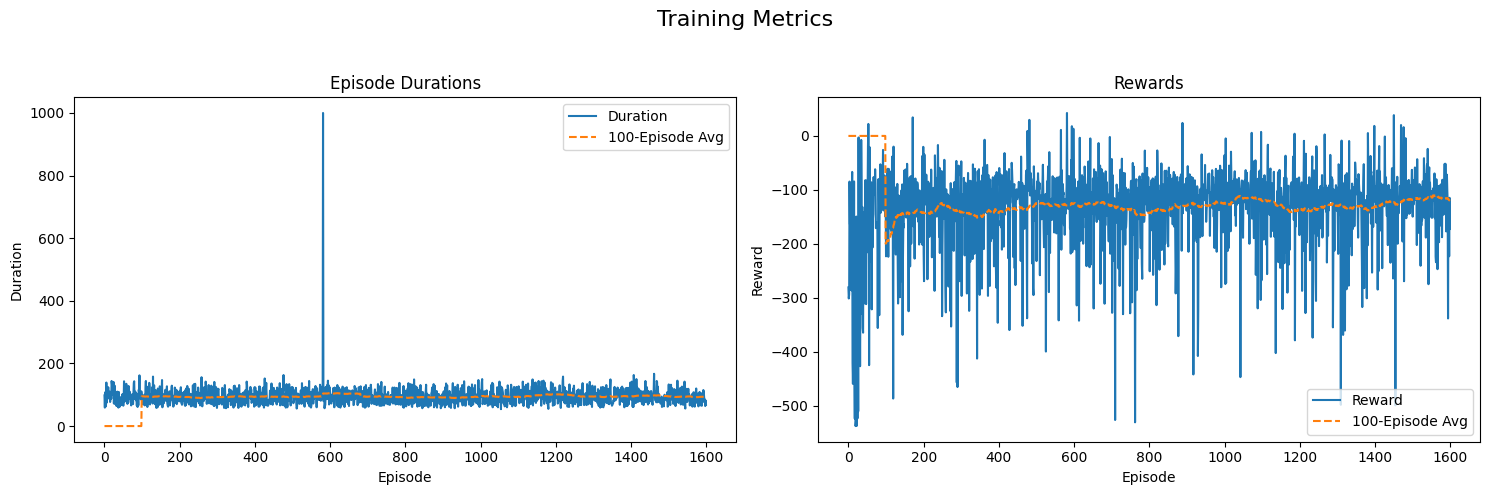

Episode 100: Average Reward: -126.25, Loss: -0.0111, Steps: 86


In [16]:
max_episodes = 100
reward_threshold = 200.0
batch_size = 16

global_track_steps_per_episode = []
global_track_reward_per_episode = []

rewards_history, loss_history, steps_history = train_vpg_policy(
    max_episodes=max_episodes, reward_threshold=reward_threshold, batch_size=batch_size
)